In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

In [2]:
df = pd.read_csv('emotions.csv')
counts = np.zeros(6)
for i in range(10000):
    counts[df['label'][i]] += 1
print(counts)

[2935. 3396.  789. 1367. 1149.  364.]


In [3]:
df.head()
df = df[:10000]

In [4]:
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['text'])
y = df['label']

In [5]:
emotion_words = {}
for emo in df['label'].unique():
    all_words = ' '.join(df[df['label'] == emo]['text']).split()
    common = [w for w, _ in Counter(all_words).most_common(100)]
    emotion_words[emo] = common

In [6]:
for emo, words in emotion_words.items():
    print(f"Top words for {emo}: {words[50:100]}")

#0 = Sadness
#1 = Joy
#2 = Love
#3 = Anger
#4 = Fear
#5 = Surprise

Top words for 4: ['still', 'had', 'can', 'he', 'really', 'ive', 'one', 'get', 'being', 'now', 'are', 'more', 'how', 'will', 'him', 'scared', 'her', 'people', 'something', 'think', 'even', 'very', 'unsure', 'from', 'anxious', 'dont', 'weird', 'reluctant', 'too', 'm', 'don', 'there', 'afraid', 'would', 'go', 'some', 'we', 'uncomfortable', 'back', 'paranoid', 'could', 'apprehensive', 'frightened', 'nervous', 'overwhelmed', 'pressured', 'also', 'agitated', 'terrified', 'going']
Top words for 0: ['little', 'how', 'very', 'more', 'will', 'if', 'are', 'from', 'ive', 'even', 'get', 'life', 'still', 'would', 'being', 'he', 'we', 'some', 'much', 'bit', 'people', 'one', 'her', 'think', 'him', 'dont', 'make', 'an', 'them', 'want', 'they', 'day', 'who', 'its', 'bad', 's', 'no', 'way', 'could', 'something', 'there', 'things', 'over', 'go', 'too', 'm', 'don', 'cant', 'their', 'feelings']
Top words for 2: ['we', 'him', 'or', 'if', 'naughty', 'how', 'hot', 'from', 't', 'do', 'had', 'myself', 'things', 

In [7]:
def get_models():
    return {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM_soft': SVC(C=1.0, kernel='rbf', probability=True),  # soft margin default C=1
        'SVM_hard': SVC(C=1e6, kernel='rbf', probability=True)  # approximate hard margin with large C
    }

In [8]:
models = get_models()

In [9]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = {name: [] for name in models}
conf_matrices = {name: np.zeros((len(np.unique(y)),) * 2, dtype=int) for name in models}
f1_scores = {name: [] for name in models}

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        fold_accuracies[name].append(acc)

        conf_matrices[name] += confusion_matrix(y_test, preds, labels=np.unique(y))

        f1 = f1_score(y_test, preds, average=None, labels=np.unique(y))
        f1_scores[name].append(f1)

        print(f"Fold {fold}, {name} - Acc: {acc:.4f}")

Fold 1, RandomForest - Acc: 0.8300
Fold 1, SVM_soft - Acc: 0.7720
Fold 1, SVM_hard - Acc: 0.8140
Fold 2, RandomForest - Acc: 0.8360
Fold 2, SVM_soft - Acc: 0.7660
Fold 2, SVM_hard - Acc: 0.8050
Fold 3, RandomForest - Acc: 0.8650
Fold 3, SVM_soft - Acc: 0.7870
Fold 3, SVM_hard - Acc: 0.8280
Fold 4, RandomForest - Acc: 0.8620
Fold 4, SVM_soft - Acc: 0.8010
Fold 4, SVM_hard - Acc: 0.8320
Fold 5, RandomForest - Acc: 0.8210
Fold 5, SVM_soft - Acc: 0.7860
Fold 5, SVM_hard - Acc: 0.8160
Fold 6, RandomForest - Acc: 0.8410
Fold 6, SVM_soft - Acc: 0.7840
Fold 6, SVM_hard - Acc: 0.8130
Fold 7, RandomForest - Acc: 0.8510
Fold 7, SVM_soft - Acc: 0.7940
Fold 7, SVM_hard - Acc: 0.8300
Fold 8, RandomForest - Acc: 0.8460
Fold 8, SVM_soft - Acc: 0.7800
Fold 8, SVM_hard - Acc: 0.8090
Fold 9, RandomForest - Acc: 0.8230
Fold 9, SVM_soft - Acc: 0.7850
Fold 9, SVM_hard - Acc: 0.8140
Fold 10, RandomForest - Acc: 0.8500
Fold 10, SVM_soft - Acc: 0.7870
Fold 10, SVM_hard - Acc: 0.8290


In [10]:
for name in models:
    avg_acc = np.mean(fold_accuracies[name])
    print(f"\n{name} average accuracy: {avg_acc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrices[name])
    print("Average F1 per class:")
    mean_f1 = np.mean(f1_scores[name], axis=0)
    for emo, score in zip(np.unique(y), mean_f1):
        print(f"{emo}: {score:.4f}")


RandomForest average accuracy: 0.8425
Confusion Matrix:
[[2509  302   16   55   47    6]
 [  77 3202   49   24   27   17]
 [  21  281  475    5    2    5]
 [  84  158    2 1079   43    1]
 [  61   93    7   39  921   28]
 [  11   49    0    3   62  239]]
Average F1 per class:
0: 0.8806
1: 0.8562
2: 0.7093
3: 0.8387
4: 0.8175
5: 0.7218

SVM_soft average accuracy: 0.7842
Confusion Matrix:
[[2654  220    7   28   24    2]
 [  86 3276   17    7    7    3]
 [  66  452  268    2    1    0]
 [ 202  275    1  866   23    0]
 [ 182  258    1   34  671    3]
 [  40  161    0    1   55  107]]
Average F1 per class:
0: 0.8612
1: 0.8152
2: 0.4935
3: 0.7508
4: 0.6943
5: 0.4407

SVM_hard average accuracy: 0.8190
Confusion Matrix:
[[2685  165    9   39   32    5]
 [  81 3240   44   13   10    8]
 [  45  369  371    2    1    1]
 [ 167  192    1  973   34    0]
 [ 149  178    1   35  767   19]
 [  33  123    0    1   53  154]]
Average F1 per class:
0: 0.8812
1: 0.8457
2: 0.6098
3: 0.8005
4: 0.7492
5: 0

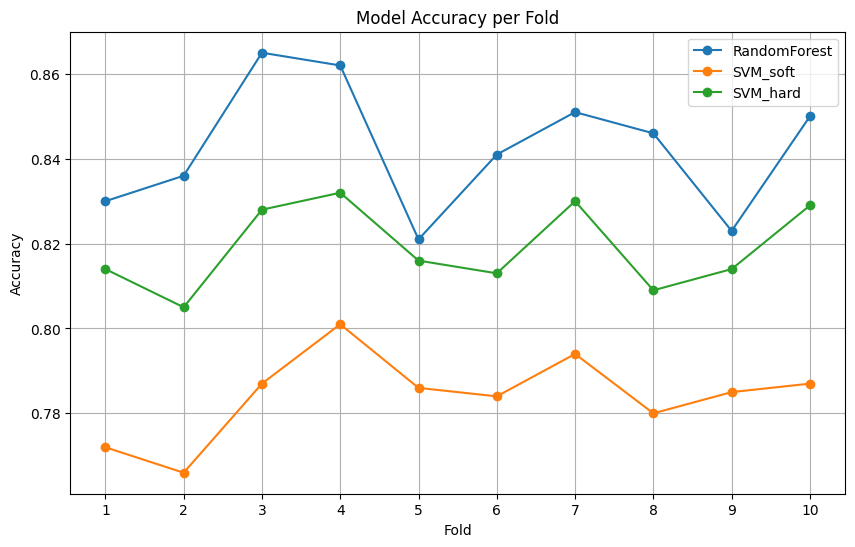

In [11]:
plt.figure(figsize=(10, 6))
for name, accs in fold_accuracies.items():
    plt.plot(range(1, len(accs)+1), accs, marker='o', label=name)
plt.title('Model Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def predict_emotion(text, model, tfidf_vectorizer):
    vectorized_text = tfidf_vectorizer.transform([text])
    prediction = model.predict(vectorized_text)

    return prediction[0]

In [13]:
input_text = "I just got a promotion at work!"

predicted_emotion_rf = predict_emotion(input_text, models['RandomForest'], tfidf)
print(f"Random Forest Prediction: {predicted_emotion_rf}")

predicted_emotion_svm_soft = predict_emotion(input_text, models['SVM_soft'], tfidf)
print(f"Soft Margin SVM Prediction: {predicted_emotion_svm_soft}")

predicted_emotion_svm_hard = predict_emotion(input_text, models['SVM_hard'], tfidf)
print(f"Hard Margin SVM Prediction: {predicted_emotion_svm_hard}")

Random Forest Prediction: 1
Soft Margin SVM Prediction: 1
Hard Margin SVM Prediction: 0
